In [1]:
import os
from os.path import dirname as up
import math
import glob
import random
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.windows import Window, get_data_window
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Polygon, MultiPolygon
import pyproj
import shapely.ops
from shapely.geometry import shape
from geopandas import GeoSeries
random.seed(10)

Functions

In [2]:
def plot_sat(path):
    """
    Plot satellite image with optional geodataframe overlay
    Args:
        path: str
        gdf_: geopandas dataframe
        linewidth: int
    """
    f, ax = plt.subplots(1,figsize=(3, 3))
    f.tight_layout()
    
    r = rio.open(path)
    r = r.read()
    r = r.transpose((1,2,0,))
    
    ax.imshow(r, origin='lower')

In [3]:
def plot_gdf(gdf_, ax=None, linewidth=2, kw='geometry'):
    """
    Plot geodataframe
    Args:
        gdf_: geopandas dataframe
        ax: matplotlib axis
        linewidth: int
        kw: str
    Returns: matplotlib axis
    """
    if ax is None:
        _,ax = plt.subplots(1,figsize=(3, 3))
        
    for geom in gdf_[kw]:
        try:
            ax.plot(*geom.exterior.xy,linewidth=linewidth)
        except AttributeError:
            # MultiPolygon
            for poly in geom.geoms:
                ax.plot(*poly.exterior.xy,linewidth=linewidth)
    return ax

In [4]:
def plot_gdf_circle(gdf_, circs, ax=None, linewidth=2, multicircs=True, kw='geometry'):
    """
    Plot geodataframe with circles
    Args:
        gdf_: geopandas dataframe
        circs: list of shapely polygons
        ax: matplotlib axis
        linewidth: int
        multicircs: bool
        kw: str
    Returns: matplotlib axis
    """
    if ax is None:
        _, ax = plt.subplots(1,figsize=(3, 3))
    
    for geom in gdf_[kw]:
        try:
            ax.plot(*geom.exterior.xy,linewidth=linewidth)
        except AttributeError:
            # MultiPolygon
            for poly in geom.geoms:
                ax.plot(*poly.exterior.xy,linewidth=linewidth)
    if multicircs:
        for circ_ in circs:
            ax.plot(*circ_.exterior.xy, linewidth=linewidth)
            ax.axis('tight')
    else: ax.plot(*circs.exterior.xy, linewidth=linewidth)
    
    return ax

In [5]:
def create_meshgrid(gdf_, step=10, kw='geometry', plot=True):
    """
    Create a meshgrid of coordinates based on the bounds of a geodataframe
    Args:
        gdf_: geopandas dataframe
        step: int
        kw: str
        plot: bool
    Returns: list of tuples of coordinates (x, y) of type float
    """
    
    xmax = max(max([(poly.bounds[0], poly.bounds[2]) for poly in gdf_[kw]]))
    ymax = max(max([(poly.bounds[1], poly.bounds[3]) for poly in gdf_[kw]]))
    # print(xmax, ymax)

    xx, yy = np.meshgrid(np.arange(0, xmax, step), 
                         np.arange(0, ymax, step))

    x = [z for x in xx for z in x]
    y = [z for x in yy for z in x]
    if plot:
        plt.plot(xx.flat, yy.flat, ".")
        plt.show()

    return list(zip(x, y))

In [6]:
def create_random_grid(gdf_, n_points, kw='geometry', plot=True):
    """
    Create a random grid of coordinates based on the bounds of a geodataframe
    Args:
        gdf_: geopandas dataframe
        n_points: int
        kw: str
        plot: bool
    Returns: list of tuples of coordinates (x, y) of type float
    """
    xmax = max(max([(poly.bounds[0], poly.bounds[2]) for poly in gdf_[kw]]))
    ymax = max(max([(poly.bounds[1], poly.bounds[3]) for poly in gdf_[kw]]))
    x = [random.uniform(0, xmax) for _ in range(n_points)]
    y = [random.uniform(0, ymax) for _ in range(n_points)]
    if plot:
        plt.plot(x, y, ".")
        plt.show()
    return list(zip(x, y))

In [7]:
def get_circle_coord(theta, x_center, y_center, radius):
    """
    Get the coordinates of a point on a circle given the angle, center, and radius
    Args:
        theta: float
        x_center: float
        y_center: float
        radius: int
    Returns: tuple of floats
    """
    x = radius * math.cos(theta) + x_center
    y = radius * math.sin(theta) + y_center
    return x, y

def get_all_circle_coords(x_center, y_center, radius, n_points):
    """
    Get all the coordinates of a circle given the center, radius, and number of points
    Args:
        x_center: float
        y_center: float
        radius: int
        n_points: int
    Returns: list of tuples of floats
    """
    thetas = [i/n_points * math.tau for i in range(n_points)]
    circle_coords_ = [get_circle_coord(theta, x_center, y_center, radius) for theta in thetas]
    return circle_coords_

def circle_coords_fn(x_center, y_center, radius, n_points, offset=(20,20)):
    """
    Compute circle coordinates using a center point (x, y)
    and radius. The number of coordinates computed is n_points.
    Args:
        x_center: float
        y_center: float
        radius: int
        n_points: int
        offset: tuple of ints  
    Returns: list of tuples of floats
    """
    thetas = [i/n_points * math.tau for i in range(n_points)]
    xoff, yoff = offset
    return [(radius*math.cos(theta)+(x_center-xoff), radius*math.sin(theta)+(y_center-yoff)) for theta in thetas]

# circle_coords = circle_coords_fn(x_center = 595134.0, 
#                                       y_center = 5751614.0,
#                                       radius = 30,
#                                       n_points = 100)

In [8]:
def get_data(tifs_path, geojsons_path):
    """
    Process tifs and geojsons to be used for pin generation
    Args:
        tifs_path: str
        geojsons_path: str   
    Returns: list of tuples of strings
    """
    tifs = sorted(glob.glob(tifs_path), key=lambda s: int(s.split("_tile_")[1].split('.')[0]))
    geojsons = sorted(glob.glob(geojsons_path), key=lambda s: int(s.split("_tile_")[1].split('.')[0]))
    geojsons = [g for g in geojsons if g.split("_tile_")[1].split('.')[0] \
                in [t.split("_tile_")[1].split('.')[0] for t in tifs]]
    datas_ = list(zip(tifs, geojsons))
    assert len(tifs) == len(geojsons), "tifs and geojsons must be of equal length"
    assert len(datas_) > 0, "no data found"
    return datas_

In [9]:
def remove_empty_geojsons(data_):
    """
    Remove empty geojsons from the data
    Args:
        data_: list of tuples of strings 
    Returns: list of tuples of strings
    """
    out_ = []
    for tif, geojson in data_:
        gdf_ = geopandas.read_file(geojson)
        if len(gdf_['geometry']) > 0:
            out_.append((tif, geojson))
    return out_

In [10]:
def scale_and_translate(data_, plot=True):
    """
    Scale and translate the geojsons to pixel coordinates
    Args:
        data_: tuple of strings
        plot: bool
    Returns: geopandas dataframe
    """
    # data_ is a tuple of (tif, geojson)
    tif = data_[0]
    gdf_ = geopandas.read_file(data_[1])
    gdf_['px_geometry'] = 0
    column_index = gdf_.columns.get_loc('geometry')
    
    src_ = rio.open(tif)
    gdf_['px_geometry'] = gdf_['geometry'].apply(lambda x: rio.transform.rowcol(src_.transform, [i[0] for i in x.exterior.coords], [i[1] for i in x.exterior.coords]) \
        if x.geom_type == 'Polygon' else [rio.transform.rowcol(src_.transform, [i[0] for i in poly.exterior.coords], [i[1] for i in poly.exterior.coords]) for poly in list(x.geoms)])

    # make the pixel geometry column a shapely polygon
    for coords in enumerate(gdf_['px_geometry']):
        try:
            gdf_.iloc[coords[0], column_index] = Polygon(list(zip(coords[1][0], coords[1][1])))
        except TypeError:
            polys = []
            for poly in coords[1]:
                polys.append(Polygon(list(zip(poly[0], poly[1]))))
            gdf_.iloc[coords[0], column_index] = MultiPolygon(polys)

    miny = min([poly.bounds[1] for poly in gdf_['geometry']])
    gdf_['tr_geometry'] = GeoSeries(gdf_['geometry']).translate(xoff=0, yoff=np.abs(miny))

    # rotate the pixel geometry
    gdf_['ro_geometry'] = GeoSeries(gdf_['tr_geometry']).rotate(270, origin=(0, 0))

    miny = min([poly.bounds[1] for poly in gdf_['ro_geometry']])
    gdf_['tr2_geometry'] = GeoSeries(gdf_['ro_geometry']).translate(xoff=0, yoff=np.abs(miny))
    
    if plot: plot_gdf(gdf_, linewidth=2, kw='geometry')
    return gdf_

In [11]:
def crop_tifs_to_geojsons(data_, kw, ckw, overwrite=False):
    """
    Crop tifs to the bounds of the geojsons
    Args:
        data_: list of tuples of strings
        kw: str
        overwrite: bool  
    Returns: list of tuples of strings
    """
    dat = []
    for tif, gjson in data_:
        input_file = tif
        fname = os.path.basename(input_file)
        save_dir = os.path.split(os.path.dirname(input_file))[0]
        if not os.path.exists(f'{save_dir}/processed/cropped/{kw}'):
            os.makedirs(f'{save_dir}/processed/cropped/{kw}')
        output_file = f'{save_dir}/processed/cropped/{kw}/{fname}'
        dat.append((output_file, gjson))
        if os.path.exists(output_file) and not overwrite:
            print(f'{output_file} already exists')
            continue
        gdf_ = scale_and_translate((tif, gjson), plot=False)
        x_max = max([poly.bounds[0] for poly in gdf_[ckw]])
        y_max = max([poly.bounds[2] for poly in gdf_[ckw]])
        with rio.open(input_file, 'r+') as src_:
            profile = src_.profile
            window = Window(0, 0, x_max, y_max)
            data_ = src_.read(window=window)
            profile.update({
                'driver': src_.driver,
                'height': window.height,
                'width': window.width,
                'transform': rio.windows.transform(window, src_.transform)
            })
            with rio.open(
                    output_file,
                    'w',
                    **profile
            ) as dst:
                dst.write(data_)
    return dat

In [12]:
def mask_and_rotate_data(data_, kw, rotate=False, overwrite=False):
    """
    Mask and rotate the data
    Args:
        data_: list of tuples of strings
        kw: str
        rotate: bool
        overwrite: bool
    Returns: list of tuples of strings
    """
    dat = []
    for tif, gjson in data_:
        input_file = tif
        fname = os.path.basename(input_file)
        save_dir = os.path.split(up(up(up(input_file))))[0]
        # use the same kw as the tifs modality
        if not os.path.exists(f'{save_dir}/processed/masked/{kw}'):
            os.makedirs(f'{save_dir}/processed/masked/{kw}')
        output_file = f'{save_dir}/processed/masked/{kw}/{fname}'
        dat.append((output_file, gjson))
        if os.path.exists(output_file) and not overwrite:
            print(f'{output_file} already exists')
            continue
        with rio.open(input_file, 'r+') as src_:
            src_.nodata = 0
            profile = src_.profile.copy()
            window = get_data_window(src_.read(masked=True))
            window_data = src_.read(window=window)
            if rotate:
                final_data = np.rot90(window_data, k=1, axes=(1, 2))
                transform = src_.window_transform(window) * rio.Affine.rotation(-90)
            else:
                final_data = window_data
                transform = src_.window_transform(window)
            profile.update(
                driver=src_.driver,
                transform=transform,
                height=window.height,
                width=window.width)
            with rio.open(
                    output_file,
                    'w',
                    **profile
            ) as dst:
                dst.write(final_data)
    return dat

In [13]:
def generate_pin_counts(data_list, rad=20, step=100, stop=6, kw='geometry', off=(20, 20), gridtype="pan", plot=True):
    """
    Generate random pins (x, y) and count of buildings 
    in a given list of geojsons
    Args:
        data_list: list of tuples of strings
        rad: int
        step: int
        stop: int
        kw: str
        off: tuple of ints
        plot: bool
    Returns: list of lists of strings and lists of tuples of floats and ints
    """
    out_ = []
    N = 0
    print(f"Using {gridtype} grid")
    for rastr, geojs in data_list:
        gdf_ = scale_and_translate((rastr, geojs), plot=plot)
        if gridtype == "pan":
            grid = np.load('pangrid.npy')
        elif gridtype == "ps-rgbnir":
            grid = np.load('psrgbnir_grid.npy')
        else:
            grid = create_meshgrid(gdf_, step=step, kw=kw, plot=plot)
        circs = [Polygon(circle_coords_fn(circ_coors[0], circ_coors[1], rad, step, offset=off)) for circ_coors in grid]
        if plot: plot_gdf_circle(gdf_, circs, multicircs=True, kw=kw)
        
        cg = list(zip(circs, grid))
        lst = [((g[0], g[1]), len(geopandas.sjoin(geopandas.GeoDataFrame(index=[0], crs='epsg:32631', geometry=[c]), gdf_))) for c,g in cg]
        out_.append([rastr, [loc for loc, _ in lst], [cnt for _, cnt in lst]])
        N += 1
        print(f"{N} of {len(data_list)}")
        if N >= stop:
            break
    return out_

In [14]:
# save array as .npy
def save_array(array, name, overwrite=False):
    """
    Save array as .npy
    Args:
        array: np.array
        name: str
    """
    if os.path.isfile(name) and not overwrite:
        print(f'{name} already exists')
    else:
        np.save(name, array)

# Main

Constants

In [60]:
# change datapath here
sample_size = 500
KW = 'PAN'
data = "../data/AOI_11_Rotterdam"

In [61]:
if os.path.exists(f"{os.path.join(data, 'processed', KW)}"):
    print("processed directory already exists")
    tifs_pth = f"{os.path.join(data, 'processed' , KW)}/*.tif"
else:
    tifs_pth = f"{os.path.join(data, KW)}/*.tif"

processed directory already exists


In [62]:
geojsons_pth =f"{os.path.join(data, 'geojson_buildings')}/*.geojson"
datas = remove_empty_geojsons(get_data(tifs_pth, geojsons_pth)[:sample_size])

In [63]:
# copy tifs from AOI_11_Rotterdam to AOI_11_Rotterdam/processed/kw
if not os.path.exists(f"{os.path.join(data, 'processed', KW)}"):
    for tif, _ in datas:
        fname = os.path.basename(tif)
        save_dir = os.path.split(os.path.dirname(tif))[0]
        if not os.path.exists(f'{save_dir}/processed/{KW}'):
            os.makedirs(f'{save_dir}/processed/{KW}')
        output_file = f'{save_dir}/processed/{KW}/{fname}'
        if os.path.exists(output_file):
            print(f'{output_file} already exists')
            continue
        os.system(f'cp {tif} {output_file}')
else:
    print("tifs already copied")

tifs already copied


In [64]:
# cropped = crop_tifs_to_geojsons(datas, KW, 'tr2_geometry', overwrite=True)

In [65]:
# masked = mask_and_rotate_data(cropped, KW, rotate=True, overwrite=True)

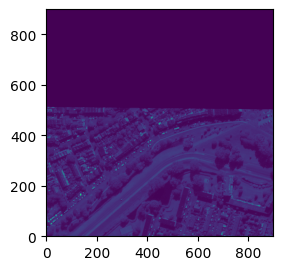

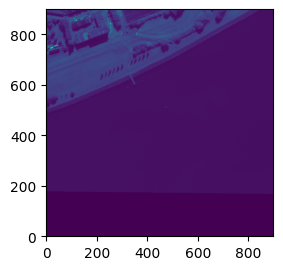

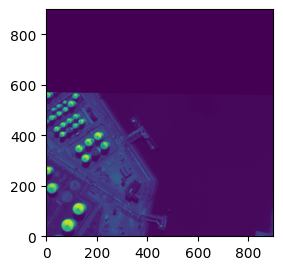

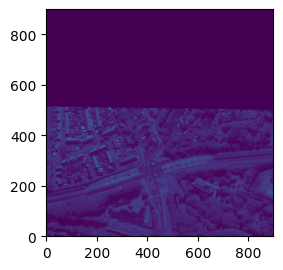

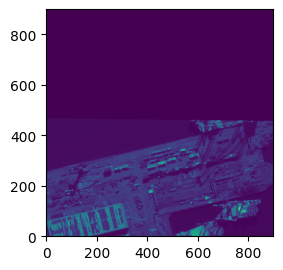

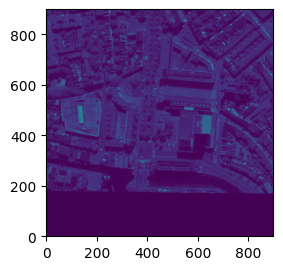

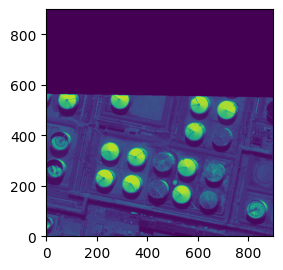

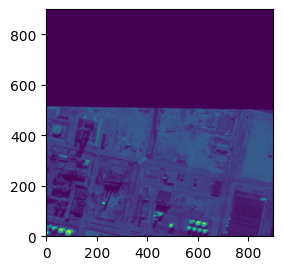

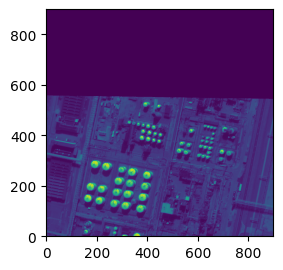

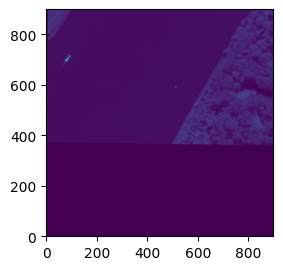

In [66]:
# plot samples
procs = glob.glob(f'../data/AOI_11_Rotterdam/processed/{KW}/*.tif')[:10]
for i, _ in enumerate(procs):
    src = rio.open(procs[i])
    plot_sat(procs[i])

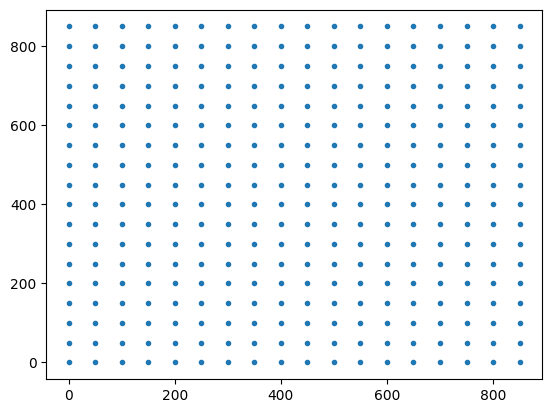

In [67]:
# an example of how to use the circle_coords_fn function to create a meshgrid of pins
testgdf = scale_and_translate(datas[0], plot=False)
circle_coords = create_meshgrid(testgdf, step=50, kw='geometry')
# circ = [Polygon(circle_coords_fn(circ_coors[0], circ_coors[1], 1, 100, offset=(0,0))) for circ_coors in circle_coords]

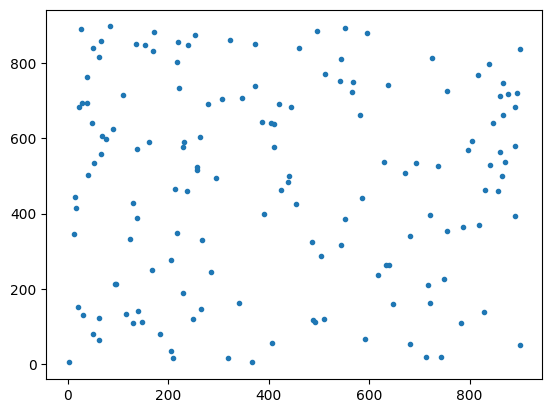

pangrid.npy already exists


In [68]:
# plot random grid
pangrid = random_coords = create_random_grid(testgdf, 150, kw='geometry', plot=True)
save_array(pangrid, 'pangrid.npy', overwrite=False)

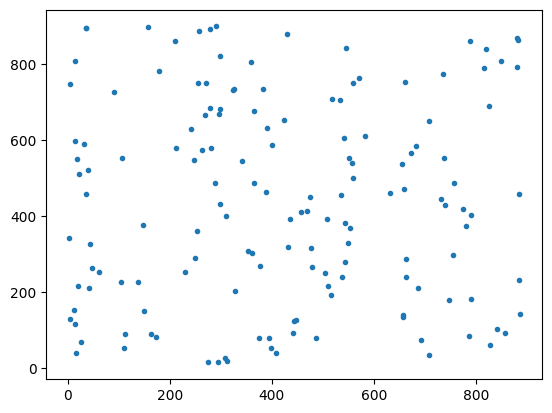

psrgbnir_grid.npy already exists


In [69]:
psrgbnir_grid = create_random_grid(testgdf, 150, kw='geometry', plot=True)
save_array(psrgbnir_grid, 'psrgbnir_grid.npy', overwrite=False)

In [70]:
# count the number of buildings intersected by each pin in the meshgrid
# CHANGE GRID TYPE HERE
import time
start = time.time()
out = generate_pin_counts(datas, rad=10, step=100, stop=len(datas), kw='geometry', off=(0, 0), gridtype="pan", plot=False)
print(f"--- {time.time() - start} seconds ---")

Using pan grid
1 of 500
2 of 500
3 of 500
4 of 500
5 of 500
6 of 500
7 of 500
8 of 500
9 of 500
10 of 500
11 of 500
12 of 500
13 of 500
14 of 500
15 of 500
16 of 500
17 of 500
18 of 500
19 of 500
20 of 500
21 of 500
22 of 500
23 of 500
24 of 500
25 of 500
26 of 500
27 of 500
28 of 500
29 of 500
30 of 500
31 of 500
32 of 500
33 of 500
34 of 500
35 of 500
36 of 500
37 of 500
38 of 500
39 of 500
40 of 500
41 of 500
42 of 500
43 of 500
44 of 500
45 of 500
46 of 500
47 of 500
48 of 500
49 of 500
50 of 500
51 of 500
52 of 500
53 of 500
54 of 500
55 of 500
56 of 500
57 of 500
58 of 500
59 of 500
60 of 500
61 of 500
62 of 500
63 of 500
64 of 500
65 of 500
66 of 500
67 of 500
68 of 500
69 of 500
70 of 500
71 of 500
72 of 500
73 of 500
74 of 500
75 of 500
76 of 500
77 of 500
78 of 500
79 of 500
80 of 500
81 of 500
82 of 500
83 of 500
84 of 500
85 of 500
86 of 500
87 of 500
88 of 500
89 of 500
90 of 500
91 of 500
92 of 500
93 of 500
94 of 500
95 of 500
96 of 500
97 of 500
98 of 500
99 of 500
100 

In [71]:
# max buildings intersected by a pin in each output array
[max(out[i][2]) for i in range(len(out))]

[1,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 3,
 1,
 2,
 3,
 1,
 5,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 1,
 0,
 0,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 4,
 2,
 4,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 1,
 3,
 2,
 2,
 1,
 3,
 2,
 3,
 2,
 3,
 4,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 4,
 4,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 3,
 1,
 2,
 3,
 1,
 0,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 3,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 4,
 3,
 4,
 2,
 3,
 1,
 2,
 3,
 3,
 3,
 2,
 2,
 4,
 3,
 3,
 2,
 3,
 1,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 4,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 4,
 2,
 4,
 2,
 1,
 1,
 1,
 3,
 2,
 2,
 3,


In [72]:
# non-zero array indices for each output array
# confirms that pins are intersecting buildings
[np.nonzero(out[i][2]) for i in range(len(out))]

[(array([  0,   3,  10,  12,  18,  21,  28,  39,  47,  49,  58,  62,  67,
          69,  71,  76,  80,  82,  88,  89,  94,  98, 105, 110, 114, 116,
         117, 118, 121, 130, 137, 144]),),
 (array([ 73,  84,  92, 124, 125, 134]),),
 (array([  0,   1,   3,   4,  10,  12,  19,  22,  39,  46,  47,  61,  62,
          63,  64,  70,  80,  82,  88, 104, 115, 119, 120, 130, 136, 141]),),
 (array([57]),),
 (array([ 0, 79, 87]),),
 (array([ 66,  87,  99, 122, 127]),),
 (array([], dtype=int64),),
 (array([127]),),
 (array([ 29, 106]),),
 (array([56, 57, 74]),),
 (array([5]),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([  1,   2,   4,   6,   7,  10,  12,  13,  14,  15,  16,  18,  19,
          21,  24,  25,  27,  28,  29,  30,  32,  35,  37,  39,  43,  45,
          46,  47,  49,  53,  56,  57,  59,  60,  62,  64,  66,  67,  68,
          69,  71,  74,  75,  76,  80,  87,  88,  90,  91,  93,  94,  95,
          96,  9

In [73]:
# save output to csv to use for model training
pd.DataFrame(out).to_csv(f'building_{KW}-random.csv')